# Assignment 3: MNIST classification using a  CNN

In [91]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
import torchvision
import torchvision.transforms as transforms

In [92]:
import os

In [93]:
os.path

<module 'posixpath' from '/home/irtaza/miniconda3/lib/python3.8/posixpath.py'>

In [94]:

# Device configuration
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [95]:
trainset = torchvision.datasets.MNIST(root="./data",train=True, download=True)

In [96]:
trainset.data.float().mean()/255, trainset.data.float().std()/255, trainset.data.max(), trainset.data.min()

(tensor(0.1307),
 tensor(0.3081),
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8))

A bit wasteful but this is the moment information we will need to standardize the distribution (mean 0, var 1) after scaling it to [0,1). Just plagiarizing the instruction manual here: using torchvision.transforms to compose the minmax scaling and the standardization procedure:

In [97]:
class ReshapeTransform:  # a custom tranformer to flatten mnist image matrices
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return t.reshape(img, self.new_size)

transform = torchvision.transforms.Compose(
    [transforms.ToTensor()
     ,transforms.Normalize((trainset.data.float().mean()/255), 
                           (trainset.data.float().std()/255))])
    

In [98]:
trainset = torchvision.datasets.MNIST(root="./data",train=True, download=True, transform=transform)
trainloader = t.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = t.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)


In [99]:
trainset  # for some reason it doesn't register anything here... I was quite confused

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.13066047430038452, std=0.30810779333114624)
           )

In [100]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

images.shape  ### but look the lambda transform is applied. Lazy evaluation is a bit weird

torch.Size([100, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


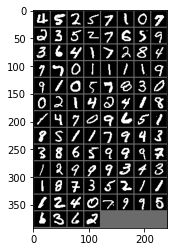

In [101]:
# show images: unsuccessful T_T => resolved
plt.imshow(np.transpose((torchvision.utils.make_grid(images.reshape(-1, 1,28,28))[:50]*255*0.3081+0.1301/0.3081).numpy(), (1,2,0)))

### Take 2: with convolutional layers

In [130]:
import torch.nn as nn
import torch.nn.functional as F

# initialize the network architechture

class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        

        self.conv1 = nn.Conv2d(1, 32, 3,1)  # 1 input channel, 32 output channels to next layer, kernel size of 3 with stride 1 (defualt, step size of convolution) 
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(9216, 500)
        
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        
        x = F.max_pool2d(x, 2)   # gather windows of height and width 2 and max over
        x = self.dropout1(x)
        
        x = t.flatten(x,1)  # flatten output, until this point considering 28x28 images
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
       
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return output


net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

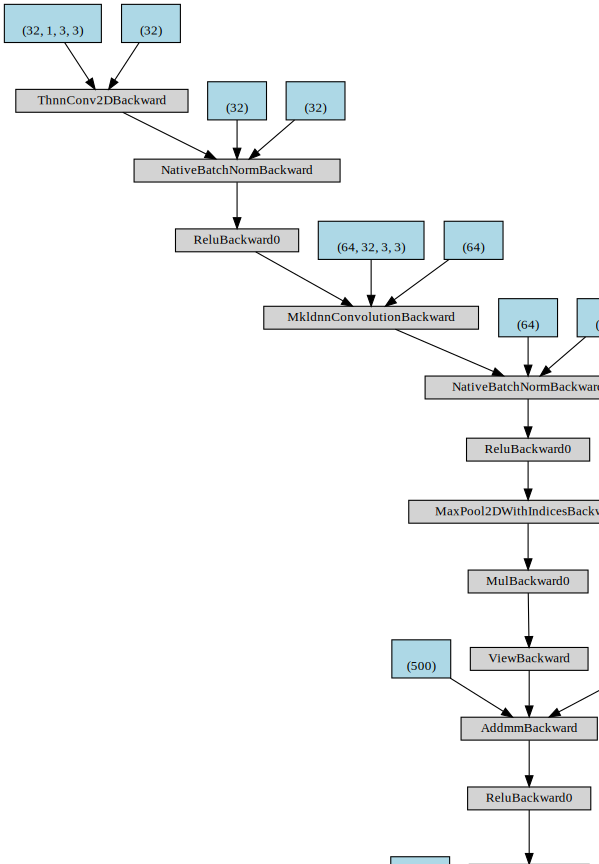

In [131]:
x = t.randn(1,1,28,28)
make_dot(Net().forward(x)) # visualize the architechture

In [119]:
import torch.optim as optim  # get an optimizer of choice

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)



Epoch [1/5], Step [100/600], Loss: 0.1798
Epoch [1/5], Step [200/600], Loss: 0.1276
Epoch [1/5], Step [300/600], Loss: 0.2189
Epoch [1/5], Step [400/600], Loss: 0.0716
Epoch [1/5], Step [500/600], Loss: 0.0466
Epoch [1/5], Step [600/600], Loss: 0.1510
Epoch [2/5], Step [100/600], Loss: 0.1326
Epoch [2/5], Step [200/600], Loss: 0.2156
Epoch [2/5], Step [300/600], Loss: 0.0783
Epoch [2/5], Step [400/600], Loss: 0.1109
Epoch [2/5], Step [500/600], Loss: 0.0177
Epoch [2/5], Step [600/600], Loss: 0.0729
Epoch [3/5], Step [100/600], Loss: 0.0418
Epoch [3/5], Step [200/600], Loss: 0.0845
Epoch [3/5], Step [300/600], Loss: 0.0231
Epoch [3/5], Step [400/600], Loss: 0.0594
Epoch [3/5], Step [500/600], Loss: 0.2120
Epoch [3/5], Step [600/600], Loss: 0.0238
Epoch [4/5], Step [100/600], Loss: 0.0295
Epoch [4/5], Step [200/600], Loss: 0.0272
Epoch [4/5], Step [300/600], Loss: 0.0380
Epoch [4/5], Step [400/600], Loss: 0.0871
Epoch [4/5], Step [500/600], Loss: 0.0417
Epoch [4/5], Step [600/600], Loss:

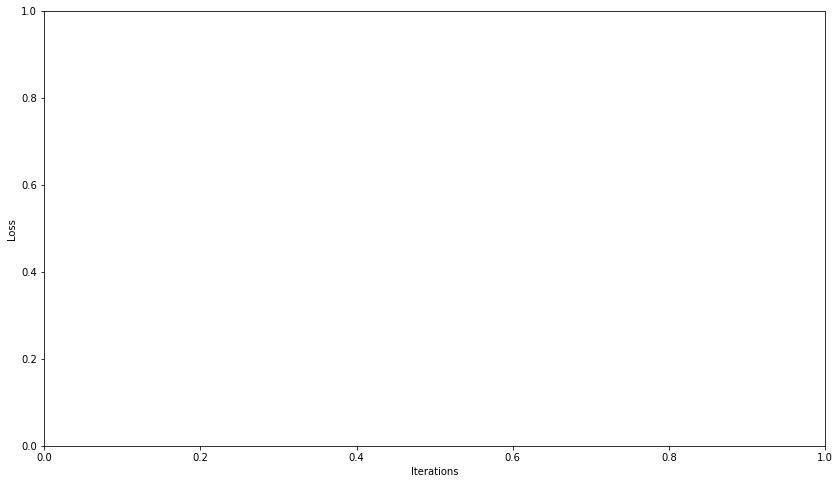

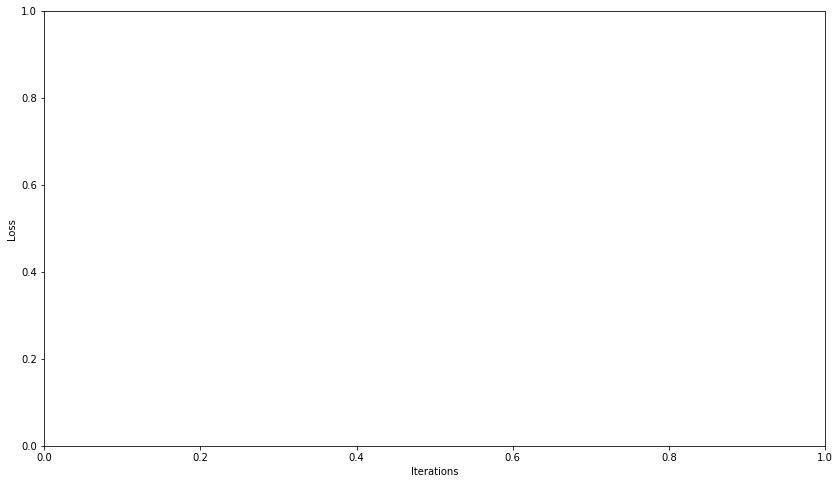

In [120]:
## train
epochs=2
total_step=len(trainloader)

iters_per_epoch = total_step

plt.figure(figsize=(14, 8))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plotted_legend = False

model = net
#optimiser = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.LambdaLR(optimiser, lr_lambda=lambda epoch: 5 if epoch == 1 else 1)
train_losses, test_losses, test_acc = [], [], 0


def plot():
    global plotted_legend
    plt.plot(range(len(train_losses)), train_losses, 'b-', label='Train')
    plt.plot([(i + 1) * iters_per_epoch - 1 for i in range(len(test_losses))], test_losses, 'r-', label='Test')
    #clear_output(wait=True)
    display(plt.gcf())
    if not plotted_legend:
        plt.legend(loc='upper right')
        plotted_legend = True

def train():
    model.train()
    for i, (x, y) in enumerate(train_loader):
        optimiser.zero_grad()
        y_hat = model(x.cuda())
        loss = F.cross_entropy(y_hat, y.cuda())
        loss.backward()
        train_losses.append(loss.item())
        optimiser.step()
        if i % 10 == 0:
            plot()

def test():
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x.cuda())
            test_loss += F.cross_entropy(y_hat, y.cuda(), reduction='sum').item()
            pred = y_hat.argmax(1, keepdim=True).cpu()
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_losses.append(test_loss / len(test_data))
    return correct / len(test_data)

#for _ in range(epochs):
#    scheduler.step()
#    train()
#    test_acc = test()


for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += loss.item()
        
        train_losses.append(loss.item())

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))
        
        #if i % 10 == 0:
        #    plot()
print('Finished Training')

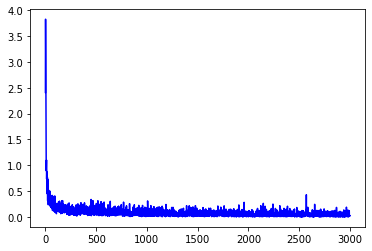

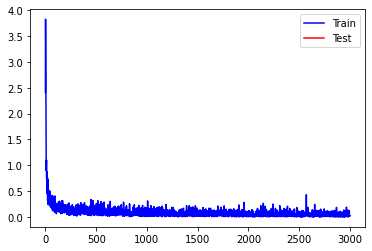

In [122]:
plot()

In [123]:
with t.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        labels = labels
        outputs = net(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.22 %


*Number of parameters used in this network:*

In [125]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(net)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    288     |
|  conv1.bias  |     32     |
|  bn1.weight  |     32     |
|   bn1.bias   |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
|  bn2.weight  |     64     |
|   bn2.bias   |     64     |
|  fc1.weight  |  4608000   |
|   fc1.bias   |    500     |
|  fc2.weight  |    5000    |
|   fc2.bias   |     10     |
+--------------+------------+
Total Trainable Params: 4632518


4632518

Wow, that's a lot of paramters and it took roughly 10 minutes (about 3 times as long) to train this model